# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [119]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import f1_score,recall_score,precision_score

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn_pandas import DataFrameMapper
from joblib import dump, load


In [120]:
# using SQLite Table to read data.
con = sqlite3.connect(r'/home/pranay/ML datasource/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 40000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (40000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [121]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [122]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [123]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [124]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [125]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [126]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [127]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(37415, 10)

In [128]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.5375

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [129]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [130]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [131]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(37415, 10)


1    31324
0     6091
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [132]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
It's Branston pickle, what is there to say. If you've never tried it you most likely wont like it. If you grew up in the UK its a staple on cheese of cold meat sandwiches. It's on my lunch sandwich today! :)
First Impression: The friendly folks over at "Exclusively Dog" heard about my website and sent me 5 of their products to test.<br />Let me just start off by saying that I Love how sweet all of these treats taste. Dad was/is considering trying one because they look and smell so much like human cookies. Plus the ingredients are very straight forward, they are probably healthier than most the stuff Mom eats... But there in lies the problem. Dad thinks that they are too sweet for a puppy of any age. The second ingredient in almost all of them is sugar. As we all know puppies have a hard time processing sugar, and just like humans can dev

In [133]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [134]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
It's Branston pickle, what is there to say. If you've never tried it you most likely wont like it. If you grew up in the UK its a staple on cheese of cold meat sandwiches. It's on my lunch sandwich today! :)
First Impression: The friendly folks over at "Exclusively Dog" heard about my website and sent me 5 of their products to test.Let me just start off by saying that I Love how sweet all of these treats taste. Dad was/is considering trying one because they look and smell so much like human cookies. Plus the ingredients are very straight forward, they are probably healthier than most the stuff Mom eats... But there in lies the problem. Dad thinks that they are too sweet for a puppy of any age. The second ingredient in almost all of them is sugar. As we all know puppies have a hard time processing sugar, and just like humans can develop d

In [135]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [136]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

First Impression: The friendly folks over at "Exclusively Dog" heard about my website and sent me 5 of their products to test.<br />Let me just start off by saying that I Love how sweet all of these treats taste. Dad was/is considering trying one because they look and smell so much like human cookies. Plus the ingredients are very straight forward, they are probably healthier than most the stuff Mom eats... But there in lies the problem. Dad thinks that they are too sweet for a puppy of any age. The second ingredient in almost all of them is sugar. As we all know puppies have a hard time processing sugar, and just like humans can develop diabetes.<br /><br />Conclusion: Your puppy is nearly guaranteed to LOVE the taste. However these should only be used as an occasional treat! If you were to feed your puppies these sugary sweet morsels every day, they would soon plump up. If you puppy is already overweight or does not exercise regularly, you may want to think twice. On the PRO side the

In [137]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [138]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

First Impression The friendly folks over at Exclusively Dog heard about my website and sent me 5 of their products to test br Let me just start off by saying that I Love how sweet all of these treats taste Dad was is considering trying one because they look and smell so much like human cookies Plus the ingredients are very straight forward they are probably healthier than most the stuff Mom eats But there in lies the problem Dad thinks that they are too sweet for a puppy of any age The second ingredient in almost all of them is sugar As we all know puppies have a hard time processing sugar and just like humans can develop diabetes br br Conclusion Your puppy is nearly guaranteed to LOVE the taste However these should only be used as an occasional treat If you were to feed your puppies these sugary sweet morsels every day they would soon plump up If you puppy is already overweight or does not exercise regularly you may want to think twice On the PRO side they are all natural with no ani

In [139]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [140]:
#filtered out whole reviews

from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
# tqdm is for printing the status bar
word_counter = []
def filterised_text(text):
    preprocessed_text = []
    for sentance in tqdm(text):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        count = len(sentance.split())
        word_counter.append(count)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text

In [141]:
preprocessed_reviews = filterised_text(final['Text'].values)
final['preprocessed_reviews']  = preprocessed_reviews
preprocessed_reviews[1822]

100%|██████████| 37415/37415 [00:11<00:00, 3149.19it/s]


'wasabi lovers want not like cheap version peanut little bit green horse radish flavor sprinkled top lots wasabi'

In [142]:
final['numbers_of_words']  = word_counter
word_counter[1822]

18

## [3.2] Preprocessing Review Summary

In [143]:
preprocessed_summary = filterised_text(final['Summary'].values)
final['preprocessed_summary']  = preprocessed_summary
preprocessed_summary[1822]

100%|██████████| 37415/37415 [00:07<00:00, 5053.69it/s]


'perfect'

In [144]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(26190,) (11225,) (26190,) (11225,)


In [145]:
avg_w2v_trained_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_100000'
avg_w2v_test_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_test_model_100000'

w2v_tf_idf_trained_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_100000'
w2v_tf_idf_test_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_test_model_100000'

In [146]:
# Common Methods

alpha_values = (1e-4, 1e-3,1e-2,0.05,1e-1,0.5, 1e0,1e1,1e2,1e3)
gamma_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]

def finding_best_alpha(X_tr,y_tr,which_method,whichAlgo, penalty):

    if whichAlgo == 'SGDClassifier' :
        # instantiate a SGDClassifier
        if penalty == 'l1':
            clf = SGDClassifier(loss='hinge', class_weight='balanced',n_jobs=-1, penalty='l1', random_state=1)
        else:
            clf = SGDClassifier(loss='hinge', class_weight='balanced',n_jobs=-1, penalty='l2', random_state=1)
        param_grid=dict(alpha=alpha_values)
    else:
        # instantiate a SVC
        clf = SVC(kernel='rbf', class_weight='balanced')
        param_grid=dict(gamma=gamma_values, C=gamma_values)
        
    #For time based splitting
    tscv = TimeSeriesSplit(n_splits=10)
    
    if which_method == 'gridsearch':
    
        # instantiate the grid for training data
        trained = GridSearchCV(clf, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1,verbose=10 )
    else:
        # instantiate the grid for training data
        trained = RandomizedSearchCV(clf, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1,verbose=10, n_iter = 15)
        
    # fit with traing data
    trained.fit(X_tr, y_tr)
    
    return trained


# plot a graph which show difference between validation error and training error
def plotAccuracyGraph(training_grid):
    alpha_range = [i for i in alpha_values]
    accuracy = [i for i in training_grid.cv_results_['mean_train_score']]
    accuracy_test = [i for i in training_grid.cv_results_['mean_test_score']]
    plt.semilogx(alpha_range, accuracy,'r',label='train_accuracy')
    plt.semilogx(alpha_range, accuracy_test,'b',label='validation_accuracy')
    plt.title('Accuracy plot')
    plt.xlabel('Alpha') 
    plt.ylabel('Accuracy')
    plt.grid('on')
    plt.legend()
    plt.show()

# https://www.geeksforgeeks.org/confusion-matrix-machine-learning/    
def plotConfusionMatrix(y_test,pred):
    # calculate confusion matrix
    cm =  confusion_matrix(y_test,pred)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
    # heatmap --> Plot rectangular data as a color-encoded matrix. 
    sns.heatmap(df_conf_matrix, annot=True, fmt='d')
    # give title to graph
    plt.title("Confusion Matrix")
    # mention axis label
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # show the plot
    plt.show()
    

# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# plot AUC curve
def plotAUC_ROC(nb_optimal,X_train, y_train, X_test, y_test):
    # predict probabilities
    test_probs = nb_optimal.predict_proba(X_test)
    train_probs = nb_optimal.predict_proba(X_train)
    
    # keep probabilities for the positive outcome only
    test_probs = test_probs[:, 1]
    train_probs = train_probs[:, 1]
    
    # calculate AUC
    test_auc = roc_auc_score(y_test, test_probs)
    train_auc = roc_auc_score(y_train, train_probs)
    
    # calculate roc curve
    train_fpr, train_tpr, thresholds = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, thresholds2 = roc_curve(y_test, test_probs)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the roc curve for the model
    pyplot.plot(train_fpr, train_tpr, 'r',marker='.', label="train AUC ="+str(train_auc))
    pyplot.plot(test_fpr, test_tpr, 'b',marker='.',label="test AUC ="+str(test_auc))
    
    pyplot.legend()
    pyplot.xlabel("K: hyperparameter")
    pyplot.ylabel("AUC")
    pyplot.title("ERROR PLOTS")
    # show the plot
    pyplot.show()
    
    return train_auc, test_auc

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


# [4] Featurization

## [4.1] BAG OF WORDS

In [147]:
##BoW

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features = 500) #in scikit-learn

# train data
X_train_bow = count_vect.fit_transform(X_train)

# test data
x_test_bow = count_vect.transform(x_test)


print('X_train_bow',X_train_bow.shape)
print('==='*10)
print('x_test_bow',x_test_bow.shape)

X_train_bow (26190, 500)
x_test_bow (11225, 500)


### Hyper parameter tuning using GridSearch

In [148]:
bow_hyperparam = '/home/pranay/Amazon Assignments/SVM RBF/bow_hyperparam_tune'
exists = os.path.isfile(bow_hyperparam)

if exists:
    print('yes exists')
    bow_train = load(bow_hyperparam)
else:
    print('not exists')
    bow_train =finding_best_alpha (X_train_bow,y_train, 'gridsearch','RBF','l2')
    dump(bow_train,bow_hyperparam)

# view the complete results (list of named tuples)
print("=======Training========")
print (bow_train.best_score_)
print (bow_train.best_params_)
print (bow_train.best_estimator_)


yes exists
=======Training========
0.8943955313168906
{'C': 1, 'gamma': 0.01}
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [149]:
gamma_val = bow_train.best_params_.get("gamma", "")
C_val = bow_train.best_params_.get("C", "")
print('\n'+color.RED+'Optimal best gamma is : '+color.END+color.BOLD+str(gamma_val)+color.END)
print('\n'+color.RED+'Optimal best C value is : '+color.END+color.BOLD+str(C_val)+color.END)


Optimal best gamma is : 0.01

Optimal best C value is : 1


## RBF SVM on BoW


Confusion Matrix for Train data


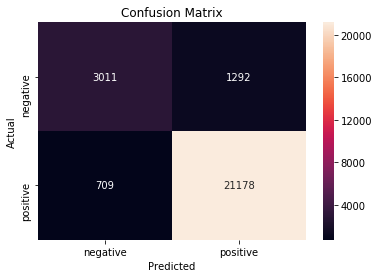


Confusion Matrix for Test data


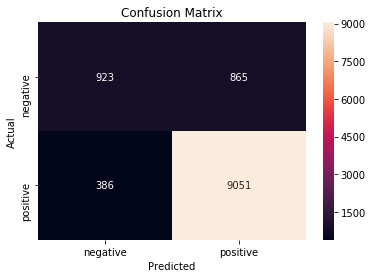

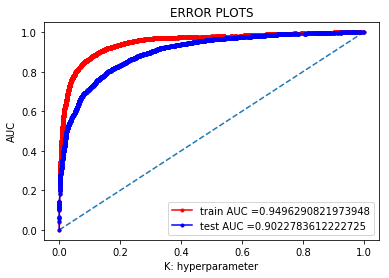


AUC (Train): 0.9496290821973948

AUC (Test): 0.9022783612222725

F1 SCORE (Train) : 0.9548887436030391

F1 SCORE (Test) : 0.9353588590916138

RECALL (Train): 0.9676063416640015

RECALL (Test): 0.9590971707110311

PRECISION  (Train) : 0.9425011125945706

PRECISION  (Test) : 0.912767244856797


In [150]:
optimal_model = SVC(C=C_val, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=gamma_val,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib.fit(X_train_bow, y_train)

# predict the response
test_pred = model_calib.predict(x_test_bow)
train_pred = model_calib.predict(X_train_bow)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib,X_train_bow, y_train,x_test_bow, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [4.3] TF-IDF

In [151]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,3), min_df=10,  max_features = 500) #in scikit-learn

# train data
X_train_tfidf = tf_idf_vect.fit_transform(X_train)

# test data
x_test_tfidf = tf_idf_vect.transform(x_test)

print('X_train_tfidf', X_train_tfidf.shape)
print('==='*10)
print('x_test_tfidf', x_test_tfidf.shape)

(26190,) (11225,) (26190,) (11225,)
X_train_tfidf (26190, 500)
x_test_tfidf (11225, 500)


### Hyper parameter tunign using GridSearch

In [177]:
tfidf_hyperparam_path = '/home/pranay/Amazon Assignments/SVM RBF/tfidf_hyperparam_tune'
exists = os.path.isfile(tfidf_hyperparam_path)

if exists:
    print('yes exists')
    tfidf_train = load(tfidf_hyperparam_path)
else:
    print('not exists')
    tfidf_train = finding_best_alpha (X_train_tfidf,y_train, 'gridsearch','RBF','l2')
    dump(tfidf_train,tfidf_hyperparam_path)


# view the complete results (list of named tuples)
print("=======Training========")
print (tfidf_train.best_score_)
print (tfidf_train.best_params_)
print (tfidf_train.best_estimator_)

gamma_val = tfidf_train.best_params_.get("gamma", "")
C_val = tfidf_train.best_params_.get("C", "")
print('\n'+color.RED+'Optimal best gamma is : '+color.END+color.BOLD+str(gamma_val)+color.END)
print('\n'+color.RED+'Optimal best C value is : '+color.END+color.BOLD+str(C_val)+color.END)

yes exists
=======Training========
0.9021741347522226
{'C': 1, 'gamma': 1}
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Optimal best gamma is : 1

Optimal best C value is : 1


## Apply RBF SVM on TFIDF


Optimal best gamma is : 0.01

Optimal best C value is : 1

Confusion Matrix for Train data


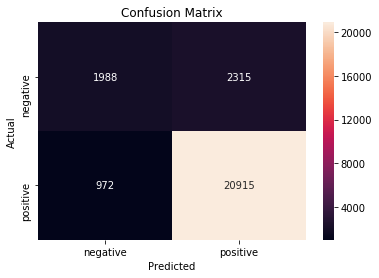


Confusion Matrix for Test data


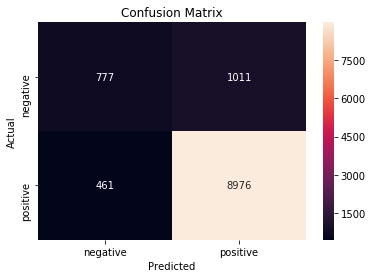

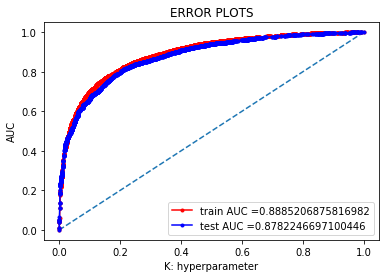


AUC (Train): 0.8885206875816982

AUC (Test): 0.8782246697100446

F1 SCORE (Train) : 0.9271449786111665

F1 SCORE (Test) : 0.9242174629324547

RECALL (Train): 0.9555900763010006

RECALL (Test): 0.9511497297870086

PRECISION  (Train) : 0.9003443822643133

PRECISION  (Test) : 0.8987683989185942


In [153]:
optimal_model = SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=gamma_val,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib.fit(X_train_tfidf,y_train)

# predict the response
test_pred = model_calib.predict(x_test_tfidf)
train_pred = model_calib.predict(X_train_tfidf)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib,X_train_tfidf, y_train,x_test_tfidf, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [4.4] Word2Vec

In [154]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(26190,) (11225,) (26190,) (11225,)


In [155]:
# Train your own Word2Vec model using your own text corpus

# Train data
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

# Test data
list_of_test_sentence = []
for sentance in x_test:
    list_of_test_sentence.append(sentance.split())

In [156]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    # train data
    w2v_model_tr=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    # train model on test data
    w2v_model_test = Word2Vec(list_of_test_sentence,min_count=5,size=50, workers=4)
    print(w2v_model_tr.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_tr.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8309053182601929), ('fantastic', 0.8299707174301147), ('amazing', 0.8037704229354858), ('good', 0.8006312847137451), ('wonderful', 0.7893585562705994), ('excellent', 0.7783764004707336), ('decent', 0.7407470345497131), ('terrific', 0.7362556457519531), ('perfect', 0.7358242273330688), ('outstanding', 0.6736037135124207)]
[('greatest', 0.7583379745483398), ('best', 0.7561699151992798), ('ive', 0.7102117538452148), ('closest', 0.7022247314453125), ('experienced', 0.7005014419555664), ('hottest', 0.6946560144424438), ('ever', 0.6806468963623047), ('nicest', 0.6774216890335083), ('tastiest', 0.675605058670044), ('tasted', 0.6648785471916199)]


In [157]:
# train data operation
w2v_train_words = list(w2v_model_tr.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[0:50])

number of words that occured minimum 5 times  9799
sample words  ['cats', 'really', 'seem', 'like', 'food', 'look', 'people', 'tuna', 'shrimp', 'variety', 'even', 'little', 'quite', 'bit', 'expensive', 'usual', 'brand', 'canned', 'cat', 'fancy', 'feast', 'obviously', 'contains', 'whole', 'seafood', 'not', 'one', 'star', 'watery', 'otherwise', 'no', 'complaints', 'unlike', 'foods', 'petite', 'cuisine', 'smell', 'bad', 'long', 'mind', 'fishy', 'would', 'buy', 'saw', 'sale', 'probably', 'pay', 'full', 'price', 'bye']


In [158]:
# test data operation
w2v_test_words = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_test_words))
print("sample words ", w2v_test_words[0:50])

number of words that occured minimum 5 times  6345
sample words  ['texture', 'flavor', 'popcorn', 'unlike', 'really', 'delicious', 'find', 'best', 'use', 'air', 'popper', 'stovetop', 'method', 'many', 'kernals', 'refuse', 'pop', 'need', 'double', 'amount', 'pour', 'full', 'cup', 'spend', 'good', 'half', 'hour', 'cleaning', 'house', 'small', 'come', 'like', 'even', 'finding', 'crunching', 'week', 'great', 'tasting', 'though', 'real', 'treat', 'home', 'roasting', 'neat', 'little', 'adventure', 'wife', 'got', 'months', 'ago']


In [159]:
# average Word2Vec

# train data operation
exists = os.path.isfile(avg_w2v_trained_model_100000)
exists = False
if exists:
    print("yes exist")
    final_w2v_train = load(avg_w2v_trained_model_100000)
else:
    print("not exist")
    # compute average word2vec for each review.
    final_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words:
                vec = w2v_model_tr.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_train.append(sent_vec)
    print(len(final_w2v_train))
    print(len(final_w2v_train[0]))
#     dump(final_w2v_train,avg_w2v_trained_model_100000)


# test data operation
exists = os.path.isfile(avg_w2v_test_model_100000)
exists = False

if exists:
    print("yes exist")
    final_w2v_test = load(avg_w2v_test_model_100000)
else:
    print("not exist")
    final_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_test_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words:
                vec = w2v_model_test.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_test.append(sent_vec)
    print(len(final_w2v_test))
    print(len(final_w2v_test[0]))
#     dump(final_w2v_test,avg_w2v_test_model_100000)

not exist


  2%|▏         | 222/11225 [00:00<00:09, 1123.37it/s]

26190
50
not exist


100%|██████████| 11225/11225 [00:14<00:00, 748.57it/s]

11225
50


### Hyper parameter tunig using GridSearch

In [160]:
w2v_hyperparam_path = '/home/pranay/Amazon Assignments/SVM RBF/w2v_hyperparam_tune'
exists = os.path.isfile(w2v_hyperparam_path)

if exists:
    print('yes exists')
    w2v_train= load(w2v_hyperparam_path)
else:
    w2v_train = finding_best_alpha (final_w2v_train,y_train, 'gridsearch','RBF','l2')
    dump(w2v_train,w2v_hyperparam_path)


# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_train.best_score_)
print (w2v_train.best_params_)
print (w2v_train.best_estimator_)

yes exists
=======Training========
0.8967242712122014
{'C': 1, 'gamma': 0.1}
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## Apply RBF SVM on W2V

In [161]:
gamma_val = w2v_train.best_params_.get("gamma", "")
C_val = w2v_train.best_params_.get("C", "")

print('\n'+color.RED+'Optimal best gamma is : '+color.END+color.BOLD+str(gamma_val)+color.END)
print('\n'+color.RED+'Optimal best C value is : '+color.END+color.BOLD+str(C_val)+color.END)


Optimal best gamma is : 0.1

Optimal best C value is : 1



Confusion Matrix for Train data


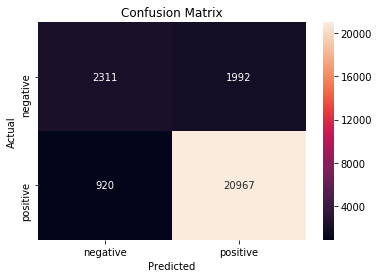


Confusion Matrix for Test data


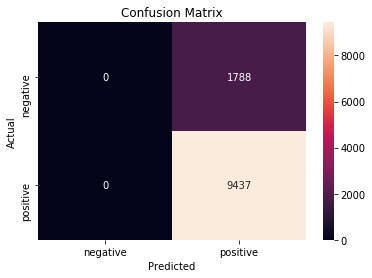

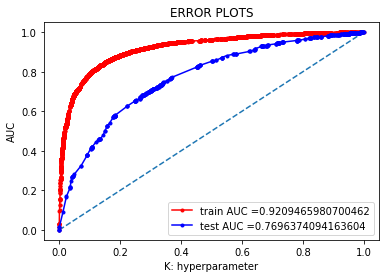


AUC (Train): 0.9209465980700462

AUC (Test): 0.7696374094163604

F1 SCORE (Train) : 0.9350666726129421

F1 SCORE (Test) : 0.9134643306553092

RECALL (Train): 0.9579659158404532

RECALL (Test): 1.0

PRECISION  (Train) : 0.9132366392264472

PRECISION  (Test) : 0.8407126948775056


In [162]:
optimal_model = SVC(C=C_val, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=gamma_val,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib.fit(final_w2v_train,y_train)

# predict the response
test_pred = model_calib.predict(final_w2v_test)
train_pred = model_calib.predict(final_w2v_train)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib,final_w2v_train, y_train,final_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

In [163]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(26190,) (11225,) (26190,) (11225,)


#### [4.4.1.2] TFIDF weighted W2v

In [164]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# TF-IDF weighted Word2Vec

# Train data operation

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_trained_model_100000)
exists = False
if exists:
    print("yes exist")
    final_tfidf_w2v_tr = load(w2v_tf_idf_trained_model_100000)
else:   
    print("not exist")
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    final_tfidf_w2v_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words and word in tfidf_feat:
                vec = w2v_model_tr.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_tr.append(sent_vec)
        row += 1
#     dump(final_tfidf_w2v_tr,w2v_tf_idf_trained_model_100000)
    
    
# Test data operation ============

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_test_model_100000)
exists = False
if exists:
    print("yes exist")
    final_tfidf_w2v_test = load(w2v_tf_idf_test_model_100000) 

else:   
    print("not exist")
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    final_tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_test_sentence): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words and word in tfidf_feat:
                vec = w2v_model_test.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_test.append(sent_vec)
        row += 1
#     dump(final_tfidf_w2v_test,w2v_tf_idf_test_model_100000)
        

not exist


  3%|▎         | 357/11225 [00:00<00:16, 675.77it/s]

not exist


100%|██████████| 11225/11225 [00:16<00:00, 697.80it/s]


### Hyper paramter tuning using Gridsearch

In [165]:
w2v_tfidf_hyperparam_path = '/home/pranay/Amazon Assignments/SVM RBF/w2v_tfidf_hyperparam_tune'

exists = os.path.isfile(w2v_tfidf_hyperparam_path)

if exists:
    print('yes exists')
    w2v_tfidf_train = load(w2v_tfidf_hyperparam_path)
else:
    print('not exists')
    w2v_tfidf_train = finding_best_alpha (final_tfidf_w2v_tr,y_train, 'gridsearch','RBF','l2')
    dump(w2v_tfidf_train,w2v_tfidf_hyperparam_path)


# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_tfidf_train.best_score_)
print (w2v_tfidf_train.best_params_)
print (w2v_tfidf_train.best_estimator_)

yes exists
=======Training========
0.8498412444277511
{'C': 0.5, 'gamma': 0.1}
SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## RBF SVM TFIDF weighted W2V 

In [166]:
gamma_val = w2v_tfidf_train.best_params_.get("gamma", "")
C_val = w2v_tfidf_train.best_params_.get("C", "")
print('\n'+color.RED+'Optimal best gamma is : '+color.END+color.BOLD+str(gamma_val)+color.END)
print('\n'+color.RED+'Optimal best C value is : '+color.END+color.BOLD+str(C_val)+color.END)


Optimal best gamma is : 0.1

Optimal best C value is : 0.5



Confusion Matrix for Train data


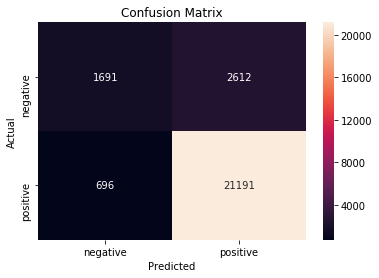


Confusion Matrix for Test data


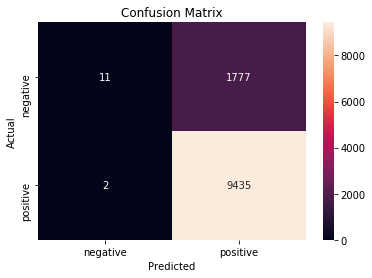

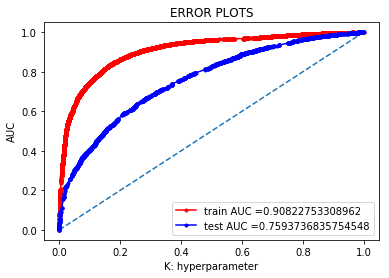


AUC (Train): 0.90822753308962

AUC (Test): 0.7593736835754548

F1 SCORE (Train) : 0.9275990369884001

F1 SCORE (Test) : 0.9138457068138892

RECALL (Train): 0.9682003015488646

RECALL (Test): 0.999788068242026

PRECISION  (Train) : 0.8902659328656052

PRECISION  (Test) : 0.8415090973956475


In [167]:
optimal_model = SVC(C=C_val, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=gamma_val,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib.fit(final_tfidf_w2v_tr,y_train)

# predict the response
test_pred = model_calib.predict(final_tfidf_w2v_test)
train_pred = model_calib.predict(final_tfidf_w2v_tr)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib,final_tfidf_w2v_tr, y_train,final_tfidf_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

# [6] Conclusions

In [183]:
import pandas as pd
from prettytable import PrettyTable

print(color.BOLD+'\t\t\t\t RBF SVM  '+color.END)
print('\n')

print(color.BOLD+'For BOW and TFIDF, We have considered 40k points'+color.END)


x = PrettyTable()
x.field_names =  ['Metric','BOW','TFIDF', 'W2V', 'TFIDF-W2V']

x.add_row(["C Value ", 1,0.5,1,0.5])
x.add_row(["gamma Value ", 0.01,1,0.1,0.1])


x.add_row(["AUC Train ", 0.9496,0.88852,0.9209,0.9082])
x.add_row(["AUC Test ", 0.90227,0.87822,0.7696,0.75937])

x.add_row(["F1 SCORE Train ", 0.95488,0.92714,0.935066,0.92759])
x.add_row(["F1 SCORE Test ", 0.93535,0.92421,0.913464,0.9138])

x.add_row(["RECALL Train ",0.9676,0.9555,0.95796,0.9682])
x.add_row(["RECALL Test ", 0.959097,0.95114,1.0,0.9997])

x.add_row(["PRECISION Train ", 0.94250,0.900344,0.9132,0.8902])
x.add_row(["PRECISION Test ",0.91276,0.89876,0.84071,0.84150])


print('\n')
print(x)

				 RBF SVM  


For BOW and TFIDF, We have considered 40k points


+------------------+----------+----------+----------+-----------+
|      Metric      |   BOW    |  TFIDF   |   W2V    | TFIDF-W2V |
+------------------+----------+----------+----------+-----------+
|     C Value      |    1     |   0.5    |    1     |    0.5    |
|   gamma Value    |   0.01   |    1     |   0.1    |    0.1    |
|    AUC Train     |  0.9496  | 0.88852  |  0.9209  |   0.9082  |
|    AUC Test      | 0.90227  | 0.87822  |  0.7696  |  0.75937  |
| F1 SCORE Train   | 0.95488  | 0.92714  | 0.935066 |  0.92759  |
|  F1 SCORE Test   | 0.93535  | 0.92421  | 0.913464 |   0.9138  |
|  RECALL Train    |  0.9676  |  0.9555  | 0.95796  |   0.9682  |
|   RECALL Test    | 0.959097 | 0.95114  |   1.0    |   0.9997  |
| PRECISION Train  |  0.9425  | 0.900344 |  0.9132  |   0.8902  |
| PRECISION Test   | 0.91276  | 0.89876  | 0.84071  |   0.8415  |
+------------------+----------+----------+----------+-----------+
